# Introduction to dataset for DS@HEP hands-on session

This example notebook is provided as an introduction for the DS@HEP tracking hands-on sessions.

Most of the content below comes directly from the starter kit that was used in the TrackML RAMP challenge during Connecting the Dots/Intelligent Tracker (https://ctdwit2017.lal.in2p3.fr/). 

Credits go to Yetkin Yilmaz, David Rousseau, Balazs Kegl, Isabell Guyon, Mikhail Hushchyn for the preparation of the challenge, dataset and descriptions.

We have removed some details about submissions for the competition as they are not relevant here.
We also removed some helper code for doing cross-validation, but that's simply for simplicity. We encourage you to use CV if you're able.

<h2> Introduction </h2>

Tracking is one of the most important tasks in a high-energy physics experiment, as it provides high-precision position and momentum information belonging to charged particles. Such information is crucial for a diverse variety of physics studies - from Standard Model tests to new particle searches - which requires robust low-level optimization without information loss which can be further refined for a narrower and more specific physics context.

<h2> Quick Glossary </h2>

We use the following vocabulary in the context of this challenge. It may be slightly different from the general high-energy physics context. Some terms are not used in the workbook, but kept here in case they are used in the discussions.

**event**: a recorded (or simulated) collision in which many particles are present, the basic unit of particle physics data

**pixel**: the smallest detector unit

**hit**: a pixel through which a particle has passed and left signal in a given event

**cluster**: a set of hits, belonging (or predicted to be belonging) to the trajectory of a single particle

**reconstruct**: same thing as predict, but may also refer to further derived quantities

**track**: a reconstructed particle, that is, a cluster but also including additional derived information, such as the overall curvature and angle

**vertex**: the point close to the center of the detector, from which the particles have originated

**impact parameter**: the shortest distance between a track and the origin

**(momentum/angle/etc) resolution** : width of the normal distribution of the difference between a predicted quantity and the true value of that quantity

<h2> Objectives </h2>

The main objective of the challenge is the optimal matching of the hits in an event. The positions of the hits in the detector are provided as input data, and the user is expected to implement a clustering scheme (trained on data if needed), so that every hit is assigned to a cluster_id.

The value of the cluster_id itself is not relevant for the task, what is relevant is which hits are clustered together, and whether this clustering corresponds well to the input particles. The score function that describes this is included in the notebook, and details will be mentioned there.

<h2> Application </h2>

The user is expected to implement the Clusterer class, which contains the __init__, fit, and predict_single_event functions.

**\__init\__** is where parameters should be set.

**fit** is the training function (not to be confused with track-fitting), where the algorithm has access to the ground-truth. This function is to be run once on an input array that contains a set of training events. The user is able to implement any event-level or particle-level segmentation of the input array in order to set up the training in any desired way.

**predict_single_event** is the function to reconstruct the hit clusters (tracks), returning an array of predicted (reconstructed) ids associated to each hit in the input array. This function takes only the hits from a single event as input, with the event_id dropped, and the RAMP machinery takes care of running this function on each event.

The **task** in the challenge is to implement this class in a way that the predict_single_event function returns a numpy array of assigned cluster_ids. At any level of this task, machine-learning techniques can be employed for sub-tasks defined by the user.

<h2> Detector </h2>

Image from the Atlas Experiment:

<img src="http://atlasexperiment.org/photos/atlas_photos/selected-photos/events/atlas2009-collision-atlantis-141749-405315-hits-web.png" alt="Drawing" style="width: 700px;"/>

The data provided to the user is a list of hit positions from a simple toy detector model that mimics the Atlas detector design (which is generic enough for recent silicon-based tracking detectors). The detector has an onion-like geometry with 9 layers surrounding the origin with polar distances of R = [39,85,155,213,271,405,562,762,1000] cm.
These layers have a very small thickness compared to the distances, therefore the thickness can be neglected.

Each layer is segmented in azimuth with high granularity. There are ($2\pi$R/pitch)+1 pixels in every layer, where pitch is 0.025 cm for layers 0-4 and 0.05 cm for layers 5-9.

Every "pixel" corresponds to the smallest detector unit defined by **layer** and **iphi** (azimuthal index).

<h2> Simulation </h2>

The challenge uses a toy model for particle generation and simulation, in which a Poisson distribution is sampled to determine the number of particles in each event, with an average of 10 particles per event.

The particles are sampled uniformly in azimuth and momentum, with bounds on the momentum. Each particle originates from a vertex that is also randomly sampled from a narrow normal distribution around the origin. The proper dimensions of the momentum and position and determination of these values for the tracks are beyond the scope of the challenge.

The particles generated this way are simulated in a uniform magnetic field. The detector material is considered to cause multiple-scattering, and this is implemented as a random rotation of the particle momentum at every detector position, sampled from a narrow normal distribution that roughly corresponds to the material of the Atlas tracker.

In addition, some hit inefficiency is simulated by a random drop of some hits (with 3% probability), and a particle stopping probability of 1% is applied at each layer to simulate effects of hadronic interactions. Keeping these in mind, the algorithms might be desired to be able to handle cases when the particle doesn't have a hit on every layer.

Since the detector has a very high granularity in azimuth, the cases where two particles pass through a single pixel are neglected (less than 0.2% probability).

## Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

Change this to point to whichever dataset you want to use.

In [2]:
filename = "public_train.csv"
df = pd.read_csv(filename)

The data consists of the following columns:
event_id, cluster_id, layer, iphi, x, y

**event_id** (integer): The event number; particles that have the same event_id belong to the same event. Notice that the event ids are not consecutive since this is a randomly sampled subset of the full sample.
**cluster_id** (integer): The true cluster_id corresponds to the particle that created the hits. The predicted cluster_id will correspond to the label of the cluster that is reconstructed. The value itself of the reconstructed cluster is irrelevant, only how the hits are grouped with those ids matters. The only requirement on the predicted cluster_ids is that they are non-negative for properly reconstructed clusters. A value of -1 means that hit is not associated to any cluster.
**layer** (integer): The detector layer that the hit sits in, representing how far the hit is from the origin. The distances of the various layers were mentioned above in *Detector*.
**iphi** (integer): The azimuthal id of the pixel along a given layer. The phi position of the hit can be determined form this value based on how many segmentations that layer has, which was described in *Detector*.
**x** (float): The x position of the hit, in cm.
**y** (float): The y position of the hit, in cm.

Notice that the information provided in data is redundant: the **layer & iphi** and **x & y** values are translatable. It is provided this way for the sake of convenience, so be careful when you need to feed algorithms with independent variables.

The array indices of the above variables may change depending on whether the event_id has been dropped or not, therefore make sure you are careful in using the index for the variable you want to pick up.

In [3]:
df

,event_id,cluster_id,layer,iphi,x,y
0,3,4,4,53253,53.900430,-265.585662
1,3,1,5,37216,-47.614439,-402.191329
2,3,1,0,7181,-4.253919,-38.767308
3,3,3,2,7937,44.418132,148.499258
4,3,4,0,7657,7.588600,-38.254583
5,3,2,7,19340,226.475161,727.566493
6,3,2,3,10947,60.079357,204.351342
7,3,2,5,10360,116.504749,387.880965
8,3,2,4,13908,76.915222,259.855823
9,3,5,2,25421,-89.080606,-126.844967


In [4]:
# Build the arrays of input variables and track labels (cluster_id)
# by dropping everything else from the dataframe with a call to drop
y = df.drop(['layer','iphi','x','y'], axis=1).values
X = df.drop(['cluster_id'], axis=1).values

### Looping over events

In [5]:
y_events = y[:,0]

In [6]:
events = np.unique(y_events)

In [7]:
# Count the number of tracks
ntrack = 0
for ev in events:
    ntrack += np.unique(y[y_events==ev][:,1]).size

In [8]:
print 'There are %d events' % events.shape[0]
print 'There are %d total tracks' % ntrack
print 'There are %d total hits' % X.shape[0]
print 'Average %g hits per track' % (float(X.shape[0]) / ntrack)
print 'There are %d hits on first layer' % X[X[:,1]==0].shape[0]
print 'There are %d hits on last layer' % X[X[:,1]==8].shape[0]

There are 5000 events
There are 49897 total tracks
There are 418059 total hits
Average 8.37844 hits per track
There are 48383 hits on first layer
There are 44654 hits on last layer


### Visualize the hits in a single event

In [9]:
ievent = 3
event_indices = X[:,0]==ievent
X_event = X[event_indices,1:] # event_id column dropped
pixelx = X_event[:,2]
pixely = X_event[:,3]
particles = y[event_indices][:,1]

**Notice that** the information provided has some redundancy. You may either use **layer and iphi** (integers) or **x and y** (floats).

In [10]:
# event_id column dropped already
X_detector = X_event[:,0:2]
X_xy = X[:,2:4]

#### Hits from all particles

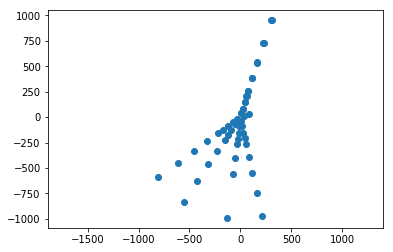

In [11]:
plt.scatter(pixelx,pixely)
plt.axis('equal')
plt.show()

This is what the algorithm will see.

#### Hits from a single particle

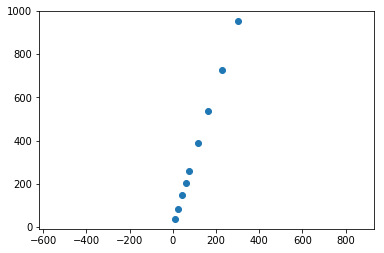

In [12]:
iparticle = 2
hits_particle = (particles == iparticle)
plt.scatter(pixelx[hits_particle],pixely[hits_particle])
plt.axis('equal')
plt.show()

So, ideally, our algorithm wants to assign specific ids to all hits in a way that corresponds to the particle. The perfect algorithm will split the event into various tracks:

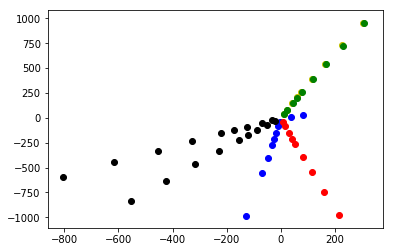

In [13]:
cmap = ['k','b','y','g','r','k','b']
for iparticle in np.unique(particles):
    hits_particle = (particles == iparticle)
    plt.scatter(pixelx[hits_particle],pixely[hits_particle],color=cmap[int(iparticle) % 7])
plt.show()

### Matching the hits together

Choose the tracking class that you want to use
(in the submission, it has to be named HitToTrackAssignment in clusterer.py)

In [14]:
from sklearn.base import BaseEstimator
from sklearn.cluster import DBSCAN

class Clusterer(BaseEstimator):
    def __init__(self, min_cos_value=0.9):
        """
        Track Pattern Recognition based on the connections between two nearest hits from two nearest detector layers.
        Parameters
        ----------
        min_cos_value : float
            Minimum cos value between two nearest segments of the track.
        """
        self.min_cos_value = min_cos_value

    def fit(self, X, y):
        pass
        
    def predict_single_event(self, X_event):
        layers, x, y = X_event[:, 0], X_event[:, 2], X_event[:, 3]
        used = np.zeros(len(x))
        labels = -1 * np.ones(len(x), dtype='int')
        track_id = 0

        # Start from a hit in the first layer
        for first_id in np.arange(0, len(x))[layers == 0]:
            track = []
            track += [first_id]
            used[first_id] = 1

            # Go through other detector layers
            for one_layer in np.unique(layers)[1:]:
                # Select hits of the layer
                hit_ids = np.arange(0, len(x))[(layers == one_layer) * (used == 0)]
                # Compute distance between hits
                diff_r = (x[track[-1]] - x[hit_ids]) ** 2\
                    + (y[track[-1]] - y[hit_ids]) ** 2
                if len(diff_r) == 0:
                    break
                # Select new track hit
                track_hit_id = hit_ids[diff_r == diff_r.min()][0]
                # Check cos of angle between two track segments
                if one_layer != 1:
                    x1, x2, x3 = x[track[-2]],  x[track[-1]], x[track_hit_id]
                    y1, y2, y3 = y[track[-2]],  y[track[-1]], y[track_hit_id]
                    dx1, dx2 = x2 - x1, x3 - x2
                    dy1, dy2 = y2 - y1, y3 - y2
                    cosine = (dx1 * dx2 + dy1 * dy2) /\
                        np.sqrt((dx1 ** 2 + dy1 ** 2) * (dx2 ** 2 + dy2 ** 2))
                    if cosine < self.min_cos_value:
                        break
                # Add new hit to the track
                track += [track_hit_id]
                used[track_hit_id] = 1
            # Label the track hits
            labels[track] = track_id
            track_id += 1
        return labels

In [15]:
tracker = Clusterer(0.8)

#### Training the algorithm

In [16]:
tracker.fit(X, y)

#### Running the algorithm to reconstruct the tracks in data
This will take some time to go through all events

In [17]:
y_true = y
y_predicted = tracker.predict_single_event(X_event)

Let's compare how well the tracks corresponds to the particles

In [18]:
df_result = pd.DataFrame({'particle':y_true[event_indices,1],'track':y_predicted}).sort_values(by='particle')
df_result

,particle,track
27,0,2
34,0,2
31,0,2
29,0,2
26,0,2
21,0,2
14,0,2
12,0,2
54,0,2
2,1,0


In [19]:
tracks = y_predicted

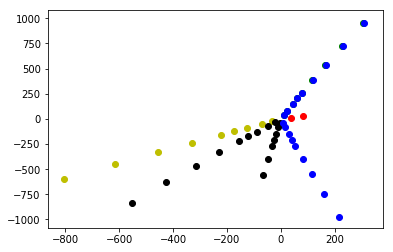

In [20]:
cmap = ['k','b','y','g','r']
for itrack in np.unique(tracks):
    if itrack >= 0:
        hits_track = (tracks == itrack)
        plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

Let's see which hits were not assigned to any cluster:

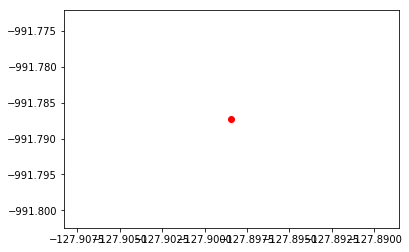

In [21]:
cmap = ['k','b','y','g','r']
itrack = -1
hits_track = (tracks == itrack)
plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

### Scoring the assignment

The score function measures the fraction of hits with good track assignment. More precisely, it is the overlap fraction between the true vs predicted cluster_id, averaged over all events. However, notice that the reconstruction algorithm has the freedom to label the indices in a way different than the true cluster_ids, therefore the "overlap" should be more clearly defined.

For this, we first determine a one-to-one matching between the true cluster_ids and predicted cluster_ids, particle-by-particle for a given event. For a given particle (defined by a single true cluster_id) the corresponding predicted cluster_id is the most frequent one among its hits. 

Once every particle is associated to a track in this way, we loop over to remove the duplicates, i.e. the tracks which contain the maximum hits of more than one particle. Among those particles, the particle with the most hits inside this track is considered to be the right match, and the other particles are considered to be lost.

After the above procedure, the well-associated hits in the event are counted, and their ratio to the total number of hits is determined as the efficiency of this event.

In the end, every event, regardless of its hit multiplicity, is considered equivalent and the efficiency is averaged over the events in the full sample.

The input to the score function is the true and predicted arrays of [event_id, cluster_id]. Note that in order for the scoring to function, the order of the hits in the predicted array must match exactly the same order in the input. If your algorithm reshuffles the order of the hits, make sure you save the original indices before doing that, and re-sort the result array corresponding to those indices.

In [22]:
def score_function(y_true, y_pred):
    '''Compute a clustering score.

    Cluster ids should be nonnegative integers. A negative integer
    will mean that the corresponding point does not belong to any
    cluster.

    We first identify assigned clusters by taking the max count of 
    unique assigned ids for each true cluster. We remove all unassigned
    clusters (all assigned ids are -1) and all duplicates (the same
    assigned id has majority in several true clusters) except the one
    with the largest count. We add the counts, then divide by the number
    of events. The score should be between 0 and 1. 

    Parameters
    ----------
    y_true : np.array, shape = (n, 2)
        The ground truth.
        first column: event_id
        second column: cluster_id
    y_pred : np.array, shape = (n, 2)
        The predicted cluster assignment.
        first column: event_id
        second column: predicted cluster_id
    """
    '''
    score = 0.
    event_ids = y_true[:, 0]
    y_true_cluster_ids = y_true[:, 1]
    y_pred_cluster_ids = y_pred

    unique_event_ids = np.unique(event_ids)
    for event_id in unique_event_ids:
        event_indices = (event_ids==event_id)
        cluster_ids_true = y_true_cluster_ids[event_indices]
        cluster_ids_pred = y_pred_cluster_ids[event_indices]

        unique_cluster_ids = np.unique(cluster_ids_true)
        n_cluster = len(unique_cluster_ids)
        n_sample = len(cluster_ids_true)

        # assigned_clusters[i] will be the predicted cluster id
        # we assign (by majority) to true cluster i 
        assigned_clusters = np.empty(n_cluster, dtype='int64')
        # true_positives[i] will be the number of points in 
        # predicted cluster[assigned_clusters[i]]
        true_positives = np.full(n_cluster, fill_value=0, dtype='int64')
        for i, cluster_id in enumerate(unique_cluster_ids):
            # true points belonging to a cluster
            true_points = cluster_ids_true[cluster_ids_true == cluster_id]
            # predicted points belonging to a cluster
            found_points = cluster_ids_pred[cluster_ids_true == cluster_id]
            # nonnegative cluster_ids (negative ones are unassigned)
            assigned_points = found_points[found_points >= 0]
            # the unique nonnegative predicted cluster ids on true_cluster[i]
            n_sub_cluster = len(np.unique(assigned_points))
            # We find the largest predicted cluster in the true cluster.
            if(n_sub_cluster > 0):
                # sizes of predicted assigned cluster in true cluster[i]
                predicted_cluster_sizes = np.bincount(
                    assigned_points.astype(dtype='int64'))
                # If there are ties, we assign the tre cluster to the predicted
                # cluster with the smallest id (combined behavior of np.unique
                # which sorts the ids and np.argmax which returns the first 
                # occurence of a tie).
                assigned_clusters[i] = np.argmax(predicted_cluster_sizes)
                true_positives[i] = len(
                    found_points[found_points == assigned_clusters[i]])
            # If none of the assigned ids are positive, the cluster is unassigned
            # and true_positive = 0
            else:
                assigned_clusters[i] = -1
                true_positives[i] = 0

        # resolve duplicates and count good assignments
        sorted = np.argsort(true_positives)
        true_positives_sorted = true_positives[sorted]
        assigned_clusters_sorted = assigned_clusters[sorted]
        good_clusters = assigned_clusters_sorted >= 0
        for i in range(len(assigned_clusters_sorted) - 1):
            assigned_cluster = assigned_clusters_sorted[i]
            # duplicates: only keep the last count (which is the largest
            # because of sorting)
            if assigned_cluster in assigned_clusters_sorted[i+1:]:
                good_clusters[i] = False
        n_good = np.sum(true_positives_sorted[good_clusters])
        score += 1. * n_good / n_sample
    score /= len(unique_event_ids)
    return score


Check the score of a single event:

In [23]:
y_pred = np.zeros((len(y_predicted),2))

y_pred[:,1] = y_predicted
y_pred[:,0] = [ievent] * len(y_predicted)

y_test_event = y[y[:,0]==ievent]

score_function(y_test_event,y_pred)

0.6545454545454545